In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math as m


In [10]:
resolution = 7
phi = np.random.rand()*2*np.pi
xAxis = np.arange(0, 1, 1/resolution)
gratingP = 1

#signal
signal = np.sin(2*np.pi*xAxis/gratingP + phi)+1
#reduce the contrast to realistic numbers
LoseContrast = signal + 2
signalP = np.random.poisson(LoseContrast)

#error bars for LoseContrast
errorBars = np.ones(len(LoseContrast))*(np.max(LoseContrast) - np.min(LoseContrast))* 0.05

#truthy signal
xT = np.linspace(0, gratingP, 1000)
signalT = np.sin(2*np.pi*xT/gratingP + phi)+3

print(xAxis)

[0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286]


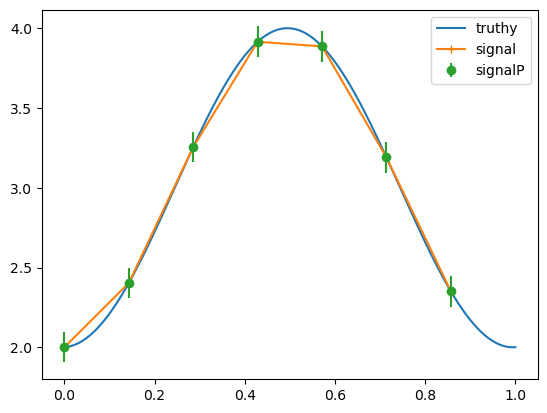

In [11]:
plt.plot(xT, signalT, label='truthy')
plt.plot(xAxis, LoseContrast,'+-',label='signal')
#add error bars
plt.errorbar(xAxis, LoseContrast, yerr=errorBars, fmt='o', label='signalP')
plt.legend()

In [12]:
#calculate the error with discrete sampling a sine wave n times
#this calculates what fraction of the full amplitude is recorded by the discrete sampling
tests = 100000
phi =  np.random.rand(tests)*2*np.pi
samples = 25
expectCon = np.zeros(samples)

#generated average maxMin difference
minMaxAvg = np.zeros(samples)
minMaxMin = np.zeros(samples)
sampleArr = np.arange(0, samples, 1)

for i in range(1, samples):
    #table for 1000 runs
    results = np.zeros(tests)
    for k in range(0, tests):
        sineArr = np.zeros(i)
        for j in range(0, i):
            sineArr[j] = np.sin(2*np.pi*j/i + phi[k])+3
        max = np.max(sineArr)
        min = np.min(sineArr)
        results[k] = max - min

    minMaxAvg[i] = np.mean(results)/2
    minMaxMin[i] = np.min(results)/2
            


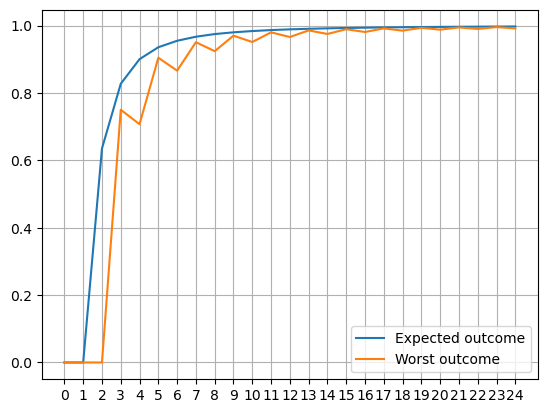

[0.         0.         0.63499936 0.82712712 0.90018212 0.9355352
 0.95470109 0.96676917 0.97461928 0.97982436 0.9835661  0.98645947
 0.98864409 0.9902888  0.99163998 0.99270903 0.99360503 0.99431269
 0.99491511 0.99544687 0.99591436 0.99627315 0.99659954 0.99689053
 0.99715694]
[0.00000000e+00 0.00000000e+00 1.51729401e-05 7.50001468e-01
 7.07115559e-01 9.04509230e-01 8.66032990e-01 9.50485169e-01
 9.23881319e-01 9.69846580e-01 9.51060961e-01 9.79746626e-01
 9.65929039e-01 9.85470934e-01 9.74929477e-01 9.89074060e-01
 9.80785571e-01 9.91486703e-01 9.84808324e-01 9.93180774e-01
 9.87688658e-01 9.94415573e-01 9.89821521e-01 9.95343028e-01
 9.91445024e-01]


In [13]:
#plot the above for the expected outcome and the worst possible
plt.plot(sampleArr, minMaxAvg, label='Expected outcome')
plt.plot(sampleArr, minMaxMin, label='Worst outcome')
plt.xticks(np.arange(0,len(sampleArr),1))
plt.grid(True)
plt.legend()
plt.show()
print(minMaxAvg)
print(minMaxMin)

#for two samples we are at the Nyquist limit therefore the worst is 0, 
#but the expected value difference of the samples is 2/3.

In [14]:
###########
#Now we can figure out the time we need to wait for each sample then multiply by the number of samples

In [15]:
def N(rate, time):
    return rate*time

def contrast(max, min):
    return (max-min)/(max+min)

def maxMin(contrast):
    return (1+contrast)/(1-contrast)

#sigma to percentile
def sigmaP(sigma):
    return m.erf(sigma/np.sqrt(2))

def timeToWait(samples, rate, sigma, contrast):
    x = (1-sigmaP(sigma))*(maxMin(contrast)-1)*(minMaxAvg[samples])
    norm = samples/rate
    return norm/x**2

def extremeTimeToWait(samples, rate, sigma, contrast):
    x = (1-sigmaP(sigma))*(maxMin(contrast)-1)*(minMaxMin[samples])
    norm = samples/rate
    return norm/x**2

#alt method

def timeToWait(samples, rate, sigma, contrast):
    x = (1-1/sigma)*(maxMin(contrast)-1)*(minMaxAvg[samples])
    norm = samples/rate
    return norm/x**2

def extremeTimeToWait(samples, rate, sigma, contrast):
    x = (1-1/sigma)*(maxMin(contrast)-1)*(minMaxMin[samples])
    norm = samples/rate
    return norm/x**2

def expDecay(lengthmm, speedMS, timeconstantUs):
    length = lengthmm/1000
    time = length / speedMS
    timeconstantS = timeconstantUs*1e-6
    return np.exp(-time/timeconstantS)

def solidAngle(detectorSizeMM, distAwayCM):
    detArea = (detectorSizeMM/1000)**2
    distAway = distAwayCM/100
    return detArea/(4*np.pi*distAway**2) * 4 #times 2 for top bottom left right


In [16]:
samplePerSin = 7 
MuRate = 1000 #per second
solidRate = MuRate * solidAngle(5, 5)
#take into account expdecay before detectors
realRate = solidRate * expDecay(1.5, 2175, 2.2)
sigma = 5 #3 sigma threshold i.e. 95th percentile
contrast = 0.3
print(timeToWait(samplePerSin, realRate, sigma, contrast)/3600)

0.0019017608706243967


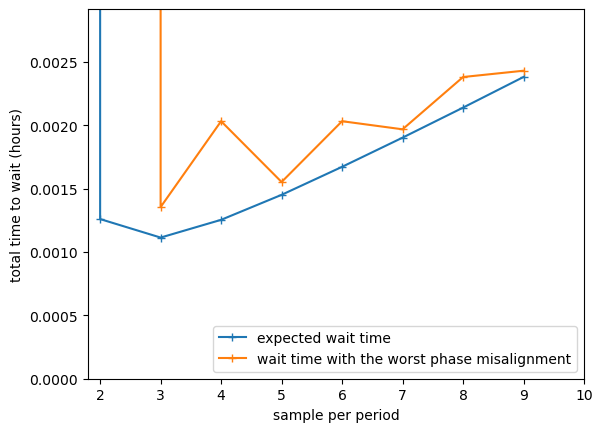

In [17]:
limit = 10
time = np.zeros(limit)
extremeTime = np.zeros(limit)
for samples in range(2,limit):
    time[samples] = timeToWait(samples, realRate, sigma, contrast)/3600
    extremeTime[samples] = extremeTimeToWait(samples, realRate, sigma, contrast)/3600

extremeTime[2] = 10000
time[1] = 10000

plt.plot(time, '+-', label='expected wait time')
plt.plot(extremeTime, '+-', label='wait time with the worst phase misalignment')
plt.xlabel('sample per period')
plt.ylabel('total time to wait (hours)')
plt.xticks(np.arange(0, limit+1, 1))
plt.xlim(1.8, limit)
plt.ylim(0, extremeTime[-1]*1.2)
#legend in bottom right corner
plt.legend(loc='lower right')

In [18]:
#this plot shows the length of time we need to wait to achieve an 'n' sigma result between distinguising 
# the the largest and smallest data points in the oscillating signal.